In [1]:
import polars as pl
import matplotlib.pyplot as plt
from event_detection_ap_score import event_detection_ap

import pandas as pd

In [2]:
# BASE_PATH = '/home/matmozaur/Downloads/child-mind-institute-detect-sleep-states/'
BASE_PATH = '../../cmidss/'

In [3]:
# x_train = pl.read_parquet(BASE_PATH+'train_series.parquet')
# y_train = pl.read_csv(BASE_PATH+'train_events.csv')

In [4]:
x = pd.read_parquet(BASE_PATH+'train_series.parquet')
y = pd.read_csv(BASE_PATH+'train_events.csv')

In [6]:
s_idxs = list(x['series_id'].unique())

In [7]:
len(s_idxs)

277

# ----------------

In [8]:
# y = y_train.filter(pl.col("series_id").is_in(s_idxs[:20])).to_pandas()

# x = x_train.filter(pl.col("series_id").is_in(s_idxs[:20])).to_pandas()

In [9]:
y = y.dropna()

In [10]:
x['timestamp'] = pd.to_datetime(x['timestamp'].apply(lambda x: x[:19]))
y['timestamp'] = pd.to_datetime(y['timestamp'].apply(lambda x: x[:19]))
x.set_index('timestamp', inplace=True)
y.set_index('timestamp', inplace=True)

x.sort_index(inplace=True)
y.sort_index(inplace=True)

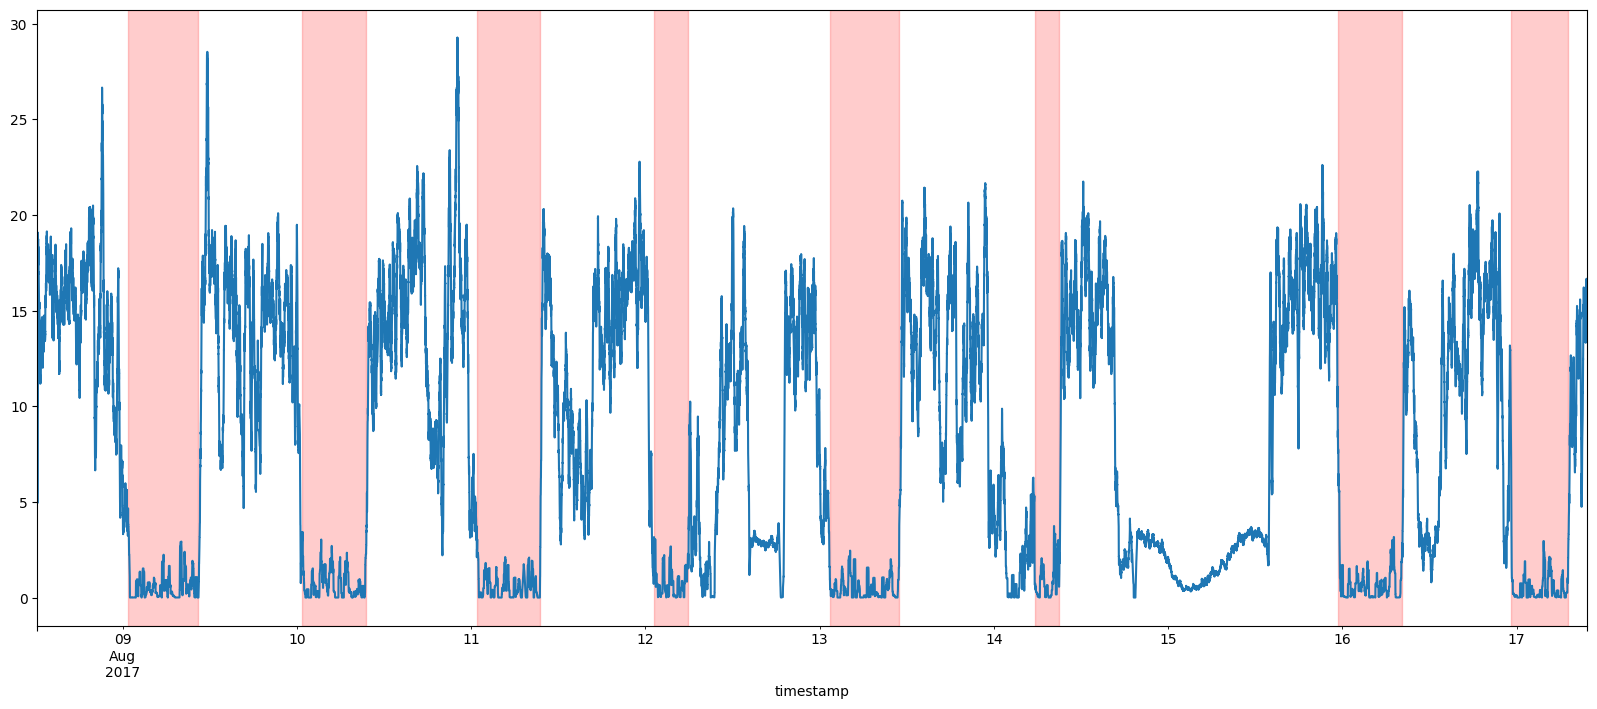

In [11]:
r = pd.to_datetime('2017-08-17 09:44:50')
s= 'ece2561f07e9'

x[x['series_id']==s]['anglez'][:r].diff().abs().rolling('15min').mean().plot(figsize=(20,8))
for a, b in zip(y[(y['event']=='onset') & (y['series_id']==s)].index,
                y[(y['event']=='wakeup') & (y['series_id']==s)].index):
    if b < r:
        plt.axvspan(a, b,alpha=0.2, color='r')

# ----------------------------

In [16]:
def fill_sleep_pred(t, fill='60min', cut='60min'):
    t = t.rolling(fill).max()
    t = t[::-1].rolling(fill).min()[::-1]

    t = t.rolling(cut).min()
    t = t[::-1].rolling(cut).max()[::-1]
    
    t = t.astype(int).diff()[2:]
    t = t[t[t==1].index[0]:]
    return t

def prepare_rows_from_sleep(t2, x, sid):
    rows = []
    last = t2.index[0] - pd.Timedelta('24h')
    i = 0 
    fail_counter = 0
    for a in t2[t2==1].index:
        if a.hour in list(range(18, 25)) + list(range(0, 3)) and a > last + pd.Timedelta('10h'):
            try:
                b = t2[a+pd.Timedelta('3h'):a+pd.Timedelta('14h')][t2[a+pd.Timedelta('3h'):a+pd.Timedelta('14h')]==-1].index[0]
                last = a
                d1 = x.loc[a][['step']].to_dict()
                i += 1
                d1['series_id'] = sid
                d1['event'] = 'onset'
                d1['score'] = 1
                rows.append(d1)
                d2 = x.loc[b][['step']].to_dict()
                if type(d2['step']) == dict:
                    d2['step'] = list(d2['step'].values())[0]
                i += 1
                d2['series_id'] = sid
                d2['event'] = 'wakeup'
                d2['score'] = 1
                rows.append(d2)
            except:
#                 b = t2[a:a+pd.Timedelta('12h')].index[-1]
#                 last = a
#                 d1 = x.loc[a][['step']].to_dict()
#                 i += 1
#                 d1['series_id'] = sid
#                 d1['event'] = 'onset'
#                 d1['score'] = 1
#                 rows.append(d1)
#                 d2 = x.loc[b][['step']].to_dict()
#                 if type(d2['step']) == dict:
#                     d2['step'] = list(d2['step'].values())[0]
#                 i += 1
#                 d2['series_id'] = sid
#                 d2['event'] = 'wakeup'
#                 d2['score'] = 0.1
#                 rows.append(d2)
                fail_counter += 1
                continue
    print(f'Failed nights: {fail_counter}')
    return rows

def prepare_sol(x, f, fill='60min', cut='60min'):
    rows = []
    for sid in x['series_id'].unique():
        x2 = x[x['series_id'] == sid]
        t = f(x2)
        t = fill_sleep_pred(t, fill, cut)
        rows += prepare_rows_from_sleep(t, x2, sid)
    pred = pd.DataFrame.from_records(rows)
    pred.sort_values(["series_id","event"], ascending=[0,1], inplace=True)
    pred.reset_index(drop=True, inplace=True)
    pred["row_id"] = pred.index
    pred = pred[["row_id", "series_id","step","event","score"]]
    return pred

def prep_trans(a):
    x_tr = a[['series_id', 'anglez', 'enmo']]

    x_tr['anglez_1_15'] = 0
    x_tr['enmo_1_15'] = 0
    x_tr['anglez_2_5'] = 0
    x_tr['enmo_2_5'] = 0

    for sid in x_tr['series_id'].unique():
        x_tr.loc[x_tr['series_id']==sid,'anglez_1_15'] =\
            x_tr[x_tr['series_id']==sid]['anglez'].diff().abs().rolling('15min').mean()
        x_tr.loc[x_tr['series_id']==sid,'enmo_1_15'] =\
            x_tr[x_tr['series_id']==sid]['enmo'].diff().abs().rolling('15min').mean()
        x_tr.loc[x_tr['series_id']==sid,'anglez_2_5'] =\
            x_tr[x_tr['series_id']==sid]['anglez'].rolling('5min').std()
        x_tr.loc[x_tr['series_id']==sid,'enmo_2_5'] =\
            x_tr[x_tr['series_id']==sid]['enmo'].rolling('5min').std()
    return x_tr

def f1(a, tr=0.5):
    x_tr = prep_trans(a)
        
    x_tr.bfill(inplace=True)
    x_tr = x_tr[['anglez', 'enmo', 'anglez_1_15', 'enmo_1_15', 'anglez_2_5', 'enmo_2_5']].values
    pred = rf2.predict_proba(x_tr)[:,1]
    return (pd.Series(pred, index=a.index) >tr).astype(int)

In [13]:
pred = prepare_sol(x, lambda a: a['anglez'].diff().abs().rolling('15min').mean() < 1.5)

Failed nights: 0
Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 1
Failed nights: 3
Failed nights: 0
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 2
Failed nights: 6
Failed nights: 0
Failed nights: 1
Failed nights: 2
Failed nights: 0
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 0
Failed nights: 1
Failed nights: 1
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 1
Failed nights: 1
Failed nights: 1
Failed nights: 1
Failed nights: 1
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 0
Failed nights:

In [14]:
event_detection_ap(y, pred)

0.2499581410216491

In [173]:
x_tr = x[['series_id', 'anglez', 'enmo']]

x_tr['anglez_1_15'] = 0
x_tr['enmo_1_15'] = 0
x_tr['anglez_2_5'] = 0
x_tr['enmo_2_5'] = 0

for sid in x_tr['series_id'].unique():
    x_tr.loc[x_tr['series_id']==sid,'anglez_1_15'] =\
        x_tr[x_tr['series_id']==sid]['anglez'].diff().abs().rolling('15min').mean()
    x_tr.loc[x_tr['series_id']==sid,'enmo_1_15'] =\
        x_tr[x_tr['series_id']==sid]['enmo'].diff().abs().rolling('15min').mean()
    x_tr.loc[x_tr['series_id']==sid,'anglez_2_5'] =\
        x_tr[x_tr['series_id']==sid]['anglez'].rolling('5min').std()
    x_tr.loc[x_tr['series_id']==sid,'enmo_2_5'] =\
        x_tr[x_tr['series_id']==sid]['enmo'].rolling('5min').std()

KeyboardInterrupt: 

In [ ]:
x_tr['sleep'] = 0
for sid in x_tr['series_id'].unique():
    for a, b in zip(y[(y['event']=='onset') & (y['series_id']==sid)].index,
                y[(y['event']=='wakeup') & (y['series_id']==sid)].index):
        x_tr.loc[a: b].loc[(x_tr.loc[a: b]['series_id']==sid),'sleep'] = 1

In [ ]:
x_tr.dropna(inplace=True)

In [ ]:
y_train =x_tr['sleep'].values

In [ ]:
x_train = x_tr[['anglez', 'enmo', 'anglez_1_15', 'enmo_1_15', 'anglez_2_5', 'enmo_2_5']].values

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
rf = RandomForestClassifier(n_estimators=10)

In [83]:
# rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10)

In [85]:
rf.score(x_train, y_train)

0.9979925619050887

In [117]:
# x_tr.bfill(inplace=True)

In [171]:
len(x_train)

9911140

In [172]:
len(y_train)

9911154

In [166]:
rf2 = RandomForestClassifier(n_estimators=1, max_depth=12)

In [167]:
rf2.fit(x_train[:8511140], y_train[:8511140])

RandomForestClassifier(max_depth=12, n_estimators=1)

In [168]:
rf2.score(x_train[:8511140], y_train[:8511140])

0.8885490075360057

In [170]:
x_train

array([[ 2.30139995e+00,  9.84999985e-02,  5.81820984e+01,
         1.69999897e-03,  4.11409568e+01,  1.20208080e-03],
       [ 1.60217991e+01,  7.37000033e-02,  3.59512486e+01,
         1.32499970e-02,  3.81736717e+01,  1.48334051e-02],
       [ 3.61208992e+01,  7.88000003e-02,  3.06671991e+01,
         1.05333303e-02,  3.95341643e+01,  1.35161608e-02],
       ...,
       [ 1.16180003e+00,  4.96000014e-02,  1.79599888e+00,
         6.12388891e-03,  2.57870743e+00,  7.77857766e-03],
       [-4.92980003e+00,  4.61999997e-02,  1.82337722e+00,
         6.13944448e-03,  2.60634579e+00,  8.25364081e-03],
       [-7.70660019e+00,  2.74999999e-02,  1.83094611e+00,
         6.23277781e-03,  2.69989911e+00,  8.25339164e-03]])

In [169]:
rf2.score(x_train[8511140:], y_train[8511140:])

ValueError: Found input variables with inconsistent numbers of samples: [1400014, 1400000]

In [107]:
# pred = rf2.predict_proba(x_train[8511140:])[:,1]

# y2 = y_train[8511140:]

# plt.plot(pred[:100000])

In [121]:
# x[8511140:]

In [ ]:
pred = prepare_sol(x, f1)

In [ ]:
event_detection_ap(y, pred)

In [160]:
# event_detection_ap(y, pred)